# Data Collection
---
## Web scraping
To collect the data, I'm scrapping the data from Skytrax: [https://www.airlinequality.com/airline-reviews/american-airlines]. Using `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [28]:
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [2]:
def parse_review(review):
    title = review.find('h2', class_='text_header').text.strip()
    author_name_tag = review.find('span', itemprop='name')
    author_location = author_name_tag.find_parent().next_sibling.strip()
    date_published = review.find('time', itemprop='datePublished').text.strip()
    review_body = review.find('div', class_='text_content').text.strip()

    # Extract ratings if available
    ratings = {}
    ratings_table = review.find('table', class_='review-ratings')
    if ratings_table:
        rows = ratings_table.find_all('tr')
        for row in rows:
            rating_category = row.find('td', class_='review-rating-header').text.strip()

            # Special handling for star ratings
            if row.find('td', class_='review-rating-stars stars'):
                star_rating = len(row.find_all('span', class_='star fill'))
                ratings[rating_category] = star_rating
            else:
                rating_value = row.find('td', class_='review-value').text.strip()
                ratings[rating_category] = rating_value

    return {
        "Title": title,
        "Author Location": author_location,
        "Date Published": date_published,
        "Review Body": review_body,
        "Ratings": ratings
    }

# Function to scrape reviews from a given page
def scrape_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    reviews = soup.find_all('div', class_='body')

    review_data = []
    for review in reviews:
        parsed_review = parse_review(review)
        review_data.append(parsed_review)

    return review_data

# Function to scrape multiple pages
def scrape_multiple_pages(base_url, start_page=1, end_page=5):
    all_reviews = []
    for page_num in range(start_page, end_page + 1):
        page_url = f"{base_url}/page/{page_num}/"
        print(f"Scraping {page_url}")
        reviews = scrape_page(page_url)
        all_reviews.extend(reviews)

    return all_reviews


base_url = 'https://www.airlinequality.com/airline-reviews/american-airlines'


start_page = 1
end_page = 100 

# Scrape reviews
all_reviews = scrape_multiple_pages(base_url, start_page=start_page, end_page=end_page)

# Convert the list of reviews into a DataFrame
reviews_df = pd.DataFrame(all_reviews)

# Expand the 'Ratings' dictionary into separate columns (if needed)
ratings_df = reviews_df['Ratings'].apply(pd.Series)
reviews_df = pd.concat([reviews_df.drop('Ratings', axis=1), ratings_df], axis=1)

# Display the DataFrame
reviews_df.head()

Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/1/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/2/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/3/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/4/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/5/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/6/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/7/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/8/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/9/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/10/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/11/
Scraping https://www.airlinequality.com/airline-reviews/american-airlines/page/12/
Scraping http

,Title,Author Location,Date Published,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended,Aircraft
0,“Incompetent and rude staff”,(United States),21st August 2024,✅ Trip Verified | Incompetent and rude staff. ...,Couple Leisure,Premium Economy,Miami to San José,August 2024,1.0,1.0,1.0,1.0,1.0,1.0,1,no,NaN
1,"""deep dissatisfaction""",(United States),21st August 2024,✅ Trip Verified | I am writing to formally e...,Family Leisure,Economy Class,Miami to New York,August 2024,NaN,NaN,NaN,NaN,1.0,NaN,1,no,NaN
2,"""Every single flight delayed""",(United States),20th August 2024,✅ Trip Verified | My husband and I are trave...,Couple Leisure,Economy Class,Charlotte to Oklahoma City,August 2024,2.0,5.0,5.0,5.0,2.0,5.0,3,no,NaN
3,"""Fly any other airline""",(United States),20th August 2024,Not Verified | We took 9 people to Las Angele...,Family Leisure,Economy Class,Dayton to Los Angeles via Chicago,May 2024,3.0,4.0,3.0,3.0,1.0,3.0,1,no,NaN
4,“shocking customer service”,(United Kingdom),19th August 2024,Not Verified | Cancelled our flight with 1hr n...,Family Leisure,Economy Class,Los Angeles to London Heathrow,August 2024,3.0,3.0,1.0,1.0,1.0,2.0,1,no,NaN


In [3]:
reviews_df.to_csv("data/AA_reviews.csv")

# Data Cleaning
---
## Steps
1. Handling missing Values
2. Remove Non-textual elements
3. Text Normalization
4. Convert date columns
5. Convert 'Recommended' column to binary values

In [4]:
def clean_text_simple(text):
    # First, remove "Trip Verified" and "Not Verified" regardless of their case
    text = text.replace("Trip Verified", "").replace("Not Verified", "")
    # Then continue with other cleaning steps
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.lower()
    text = re.sub(r'\d+', '', text) 
    text = text.strip()
    return text

In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   1000 non-null   object 
 1   Author Location         1000 non-null   object 
 2   Date Published          1000 non-null   object 
 3   Review Body             1000 non-null   object 
 4   Type Of Traveller       1000 non-null   object 
 5   Seat Type               1000 non-null   object 
 6   Route                   987 non-null    object 
 7   Date Flown              1000 non-null   object 
 8   Seat Comfort            947 non-null    float64
 9   Cabin Staff Service     940 non-null    float64
 10  Food & Beverages        701 non-null    float64
 11  Inflight Entertainment  629 non-null    float64
 12  Ground Service          974 non-null    float64
 13  Wifi & Connectivity     619 non-null    float64
 14  Value For Money         1000 non-null   i

In [6]:
#drop aircraft and wifi & connectivity columns
data_cleaned = reviews_df.drop(columns=['Aircraft'])

# Convert Date to datetime format
data_cleaned['Date Published'] = pd.to_datetime(data_cleaned['Date Published'], errors='coerce')

# Convert Recommended to binary format
data_cleaned['Recommended'] = data_cleaned['Recommended'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

# remove any unnecessary text
data_cleaned['Review Body'] = data_cleaned['Review Body'].apply(clean_text_simple)
data_cleaned['Author Location'] = data_cleaned['Author Location'].apply(clean_text_simple)
data_cleaned['Title'] = data_cleaned['Title'].apply(clean_text_simple)

data_cleaned.head()


,Title,Author Location,Date Published,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Recommended
0,incompetent and rude staff,united states,2024-08-21,incompetent and rude staff since may weve had ...,Couple Leisure,Premium Economy,Miami to San José,August 2024,1.0,1.0,1.0,1.0,1.0,1.0,1,0
1,deep dissatisfaction,united states,2024-08-21,i am writing to formally express my deep dissa...,Family Leisure,Economy Class,Miami to New York,August 2024,NaN,NaN,NaN,NaN,1.0,NaN,1,0
2,every single flight delayed,united states,NaT,my husband and i are traveling on vacation and...,Couple Leisure,Economy Class,Charlotte to Oklahoma City,August 2024,2.0,5.0,5.0,5.0,2.0,5.0,3,0
3,fly any other airline,united states,NaT,we took people to las angeles on vacation our...,Family Leisure,Economy Class,Dayton to Los Angeles via Chicago,May 2024,3.0,4.0,3.0,3.0,1.0,3.0,1,0
4,shocking customer service,united kingdom,NaT,cancelled our flight with hr notice at pm weat...,Family Leisure,Economy Class,Los Angeles to London Heathrow,August 2024,3.0,3.0,1.0,1.0,1.0,2.0,1,0


# EDA (Exploratory Data Analysis)
---
##1. Ratio of positive and negative reviews

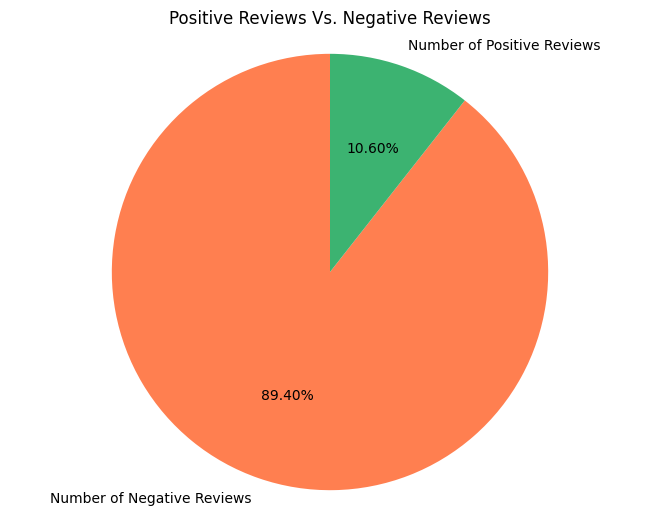

In [7]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(data_cleaned[data_cleaned['Recommended'] == 0]), len(data_cleaned[data_cleaned['Recommended'] == 1])]

ax.pie(values, 
       labels = ['Number of Negative Reviews', 'Number of Positive Reviews'], 
       colors=['coral', 'mediumseagreen'],
       shadow=False,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews')
plt.show()

##2. Violin plot of ratings for different service aspects

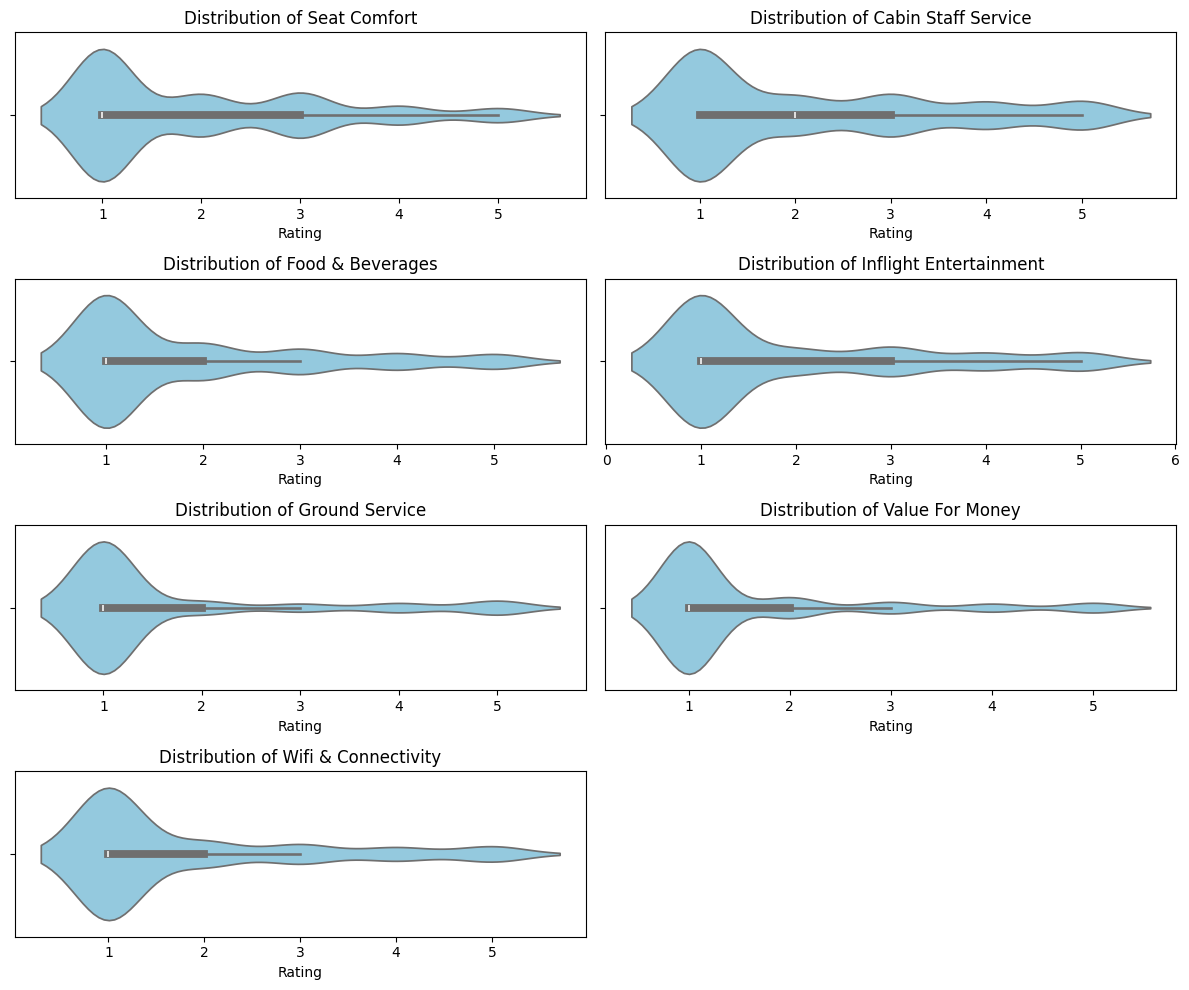

In [8]:
rating_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
                  'Inflight Entertainment', 'Ground Service', 'Value For Money', 'Wifi & Connectivity']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Plot violin plots for each rating column
for i, col in enumerate(rating_columns):
    sns.violinplot(data=data_cleaned, x=col, ax=axes[i], inner="box", color='skyblue')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Rating')

# Remove the empty subplot if there is one
if len(rating_columns) < len(axes):
    fig.delaxes(axes[-1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

###Observations:
- The majority of the service aspects, such as seat comfort, food & beverages, and value for money, received predominantly low ratings, indicating overall dissatisfaction among customers.

- **Cabin staff service** has a slightly higher median ratings and more spread-out distributions, indicating mixed feelings among customers.

- There are outliers with higher ratings in all aspects, suggesting that while most customers are dissatisfied, some had positive experiences.

##3. Violin plot of overall ratings by country (top 10 countries)


In [9]:
reviews_by_country = data_cleaned['Author Location'].value_counts()
print("Reviewers came from " + str(len(reviews_by_country)) + " different countries")
print("Here are the top 10 countries by the number of reviews:")
reviews_by_country.head()


Reviewers came from 33 different countries
Here are the top 10 countries by the number of reviews:


Author Location
united states     893
canada             30
united kingdom     22
germany             9
australia           8
Name: count, dtype: int64

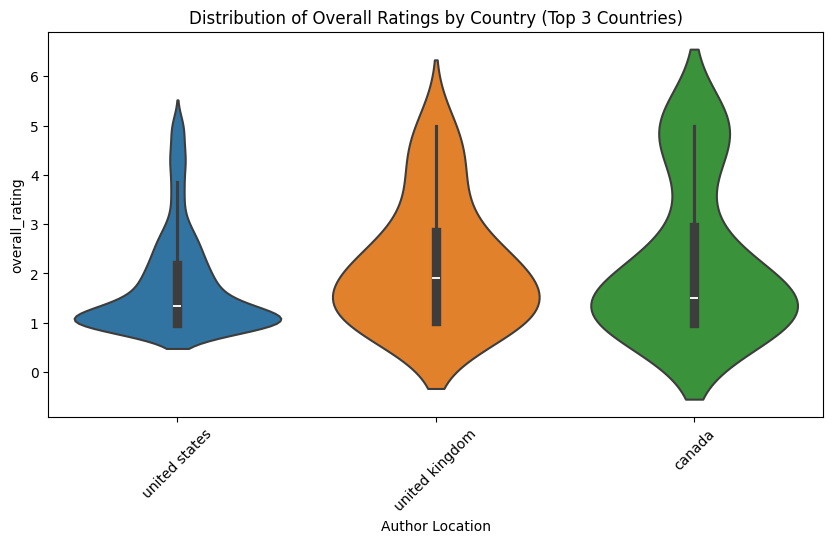

In [11]:
# Get the top 10 countries by the number of reviews
top_3_countries = reviews_by_country.head(3).index

# Filter the data to include only the top 10 countries
top_3_data = data_cleaned[data_cleaned['Author Location'].isin(top_3_countries)]

# Select the columns of interest
columns_of_interest = ['Author Location', 'Seat Comfort', 'Cabin Staff Service', 
                       'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 
                       'Value For Money', 'Wifi & Connectivity']

# Create a new column "overall_rating" that calculates the average rating across the selected columns
data_cleaned['overall_rating'] = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                                               'Food & Beverages', 'Inflight Entertainment', 
                                               'Ground Service', 'Value For Money', 'Wifi & Connectivity']].mean(axis=1)


# Plot the violin plot for the top 10 countries using the overall_rating
plt.figure(figsize=(10, 5))
sns.violinplot(x='Author Location', y='overall_rating', hue='Author Location',
               data=data_cleaned[data_cleaned['Author Location'].isin(top_3_countries)], 
               inner="box", linewidth=1.5) 
plt.xticks(rotation=45)
plt.title('Distribution of Overall Ratings by Country (Top 3 Countries)')
plt.show()

### Observations

- **Variability in Ratings:** Both the United Kingdom and Canada show a wider distribution of ratings compared to the United States, indicating more variability in customer experiences.

- **Lower Median Ratings:** The median ratings for all three countries are on the lower end of the scale, suggesting that overall customer satisfaction is not very high.
- **Mixed Experiences:** The presence of both high and low ratings in the United Kingdom and Canada suggests that while some customers have positive experiences, a significant number of customers are dissatisfied.

In [12]:
# Calculate review counts (number of non-null entries) for each rating category
review_counts = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                              'Food & Beverages', 'Inflight Entertainment', 
                              'Ground Service', 'Value For Money', 'Wifi & Connectivity']].count()

# Calculate the average rating for each category
average_ratings = data_cleaned[['Seat Comfort', 'Cabin Staff Service', 
                                'Food & Beverages', 'Inflight Entertainment', 
                                'Ground Service', 'Value For Money', 'Wifi & Connectivity']].mean()

# Create a summary DataFrame to display review counts and average ratings
summary_df = pd.DataFrame({
    'Review Count': review_counts,
    'Average Rating': average_ratings
})
print(summary_df)

                        Review Count  Average Rating
Seat Comfort                     947        1.968321
Cabin Staff Service              940        2.176596
Food & Beverages                 701        1.861626
Inflight Entertainment           629        1.930048
Ground Service                   974        1.638604
Value For Money                 1000        1.584000
Wifi & Connectivity              619        1.801292


#Text Analytics
---
##1. WordClouds

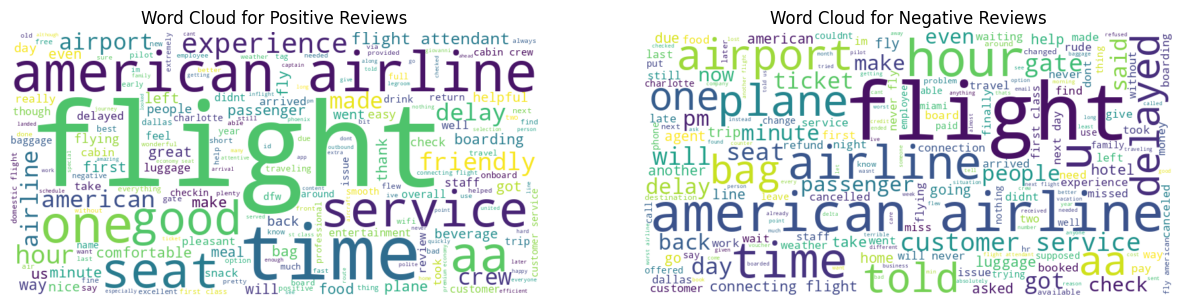

In [13]:
positive_reviews = data_cleaned[data_cleaned['Recommended'] == 1]['Review Body']
negative_reviews = data_cleaned[data_cleaned['Recommended'] == 0]['Review Body']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Concatenate all the review texts
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)


plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

###Oberservations
Positive Reviews:

- "Good," "Service," "Friendly," "Seat," "Crew": These words are prominent, suggesting that customers frequently highlighted good service, friendly staff, and a satisfactory experience with seating and the crew in their positive reviews.

- "Time," "Experience," "Easy," "Comfortable": Words like these indicate that customers often had a smooth and pleasant experience with the airline, appreciating the comfort and ease of their travels.

- "Luggage," "Airport," "Check-in": These terms suggest that positive experiences also included smooth handling of luggage, good airport experiences, and efficient check-in processes.
- Brand Mention: "American" and "Airline" appear frequently, which is expected as customers often mention the airline directly in their positive feedback.

Negative Reviews:
- "Delayed," "Time," "Hour": These words are significantly prominent, showing that delays and time-related issues are a major source of dissatisfaction among customers.

- "Service," "Told," "Said": The prominence of "service" in both positive and negative reviews indicates that customer service experiences can vary greatly. The words "told" and "said" might reflect communication issues or dissatisfaction with the responses received from airline staff.
- "Bag," "Luggage," "Lost," "Gate": Issues related to baggage handling, lost luggage, and gate problems are common complaints among customers, as these words are prominently featured in the negative word cloud.

- "Cancelled," "Late," "Never": These words point to frustrations with flight cancellations, late departures, and unmet expectations ("never" likely reflecting things that were promised but not delivered).

##2. Sensitivity analysis

In [14]:
# Function to classify sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis
data_cleaned['Sentiment'] = data_cleaned['Review Body'].apply(get_sentiment)

/var/folders/km/6m6wt0n50mjdjd15836087r40000gn/T/ipykernel_25505/3476771657.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x='Sentiment', palette={'Positive': 'mediumseagreen', 'Negative': 'coral', 'Neutral': 'blue'})


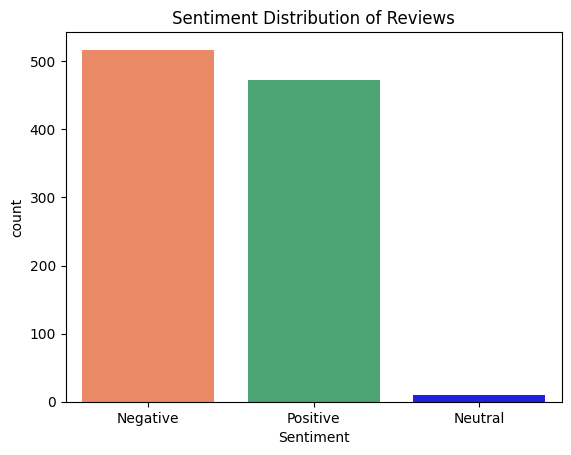

In [15]:
sns.countplot(data=data_cleaned, x='Sentiment', palette={'Positive': 'mediumseagreen', 'Negative': 'coral', 'Neutral': 'blue'})
plt.title('Sentiment Distribution of Reviews')
plt.show()

In [16]:
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

data_cleaned['Subjectivity'] = data_cleaned['Review Body'].apply(subjectivity)
data_cleaned['Polarity'] = data_cleaned['Review Body'].apply(polarity)

In [17]:

custom_color_map = {'Positive': 'mediumseagreen', 'Negative': 'coral', 'Neutral': 'blue'}
fig = px.scatter(data_cleaned, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color='Sentiment',
                 size='Subjectivity',
                 color_discrete_map=custom_color_map)
# Add a vertical line at x=0 for Neutral Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type='line',
                               yref='paper', y0=0, y1=1, 
                               xref='x', x0=0, x1=0)],
                  xaxis_title='Polarity',
                  yaxis_title='Subjectivity')

fig.show()

###Observations

- The plot shows a clear distinction between positive and negative sentiments based on polarity, with neutral sentiments clustered around zero polarity.

- Negative sentiments tend to be more subjective compared to positive sentiments.

- Positive reviews tend to be more evenly distributed across different levels of subjectivity, while negative reviews show more variation in subjectivity.

In [18]:
# Combine all reviews into a single list
all_reviews = data_cleaned['Review Body'].tolist()

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(all_reviews)

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the average TF-IDF score for each word
average_tfidf_scores = tfidf_matrix.mean(axis=0).A1

# Create a DataFrame with words and their average TF-IDF scores
tfidf_scores_df = pd.DataFrame({'word': feature_names, 'tfidf_score': average_tfidf_scores})

# Sort the DataFrame by TF-IDF score in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 20 words with the highest TF-IDF scores
print(tfidf_scores_df.head(20))

          word  tfidf_score
1254    flight     0.082060
132   american     0.044839
100   airlines     0.039281
99     airline     0.034171
3179      time     0.033142
824    delayed     0.032087
1524     hours     0.031723
2796   service     0.030182
2308     plane     0.028219
0           aa     0.027940
772   customer     0.027907
1262       fly     0.027505
1338      gate     0.026447
1255   flights     0.026012
103    airport     0.025271
3193      told     0.023906
794        day     0.022548
1372       got     0.021174
1705      just     0.021096
3499     worst     0.020299


Remove Less Informative Words:
Removing words like "flight", "american", "airlines", "airline", "time", "day", "just", "got" as they are less specific and more general. This will help us focus on more meaningful terms.

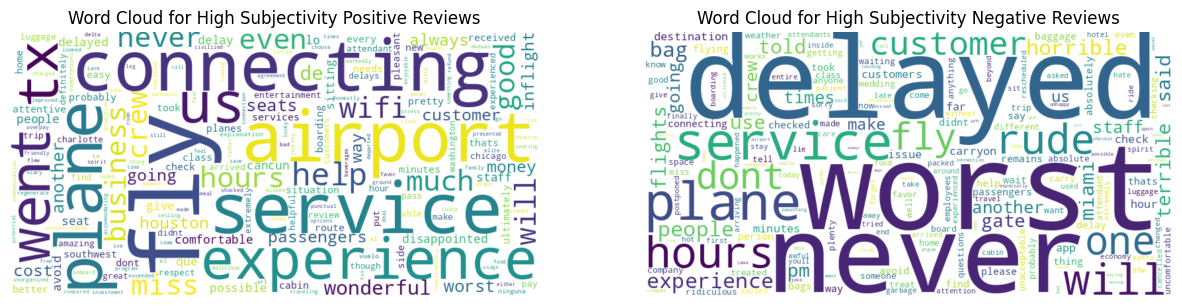

In [19]:
# Filter reviews with high subjectivity
high_subjectivity_reviews = data_cleaned[data_cleaned['Subjectivity'] > 0.7]
# Separate the high subjectivity reviews into positive and negative
positive_high_subjectivity = high_subjectivity_reviews[high_subjectivity_reviews['Sentiment'] == 'Positive']
negative_high_subjectivity = high_subjectivity_reviews[high_subjectivity_reviews['Sentiment'] == 'Negative']

stopwords = set(STOPWORDS)
custom_stopwords = { "aa","flight", "american", "airlines", "airline", "time", "day", "just", "got"} 
stopwords = stopwords.union(custom_stopwords)

def clean_and_split(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    words = text.split()
    words = [word for word in words if word not in stopwords]  
    return words

# Get word frequencies for positive and negative high subjectivity reviews
positive_words = positive_high_subjectivity['Review Body'].apply(clean_and_split).sum()
negative_words = negative_high_subjectivity['Review Body'].apply(clean_and_split).sum()
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_freq)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_word_freq)

# Plot the word clouds side by side
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Subjectivity Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for High Subjectivity Negative Reviews')

plt.show()

###Obeservations
- Service Quality: Both positive and negative reviews frequently mention service, but with contrasting sentiments. Positive reviews highlight good service and helpful crew, while negative reviews focus on rude staff and poor customer service.

- Flight Experience: Timeliness and smooth connections are key to positive experiences, whereas delays and long wait times are major sources of negative sentiment.

- Airport and In-Flight Amenities: Positive reviews appreciate good airport experiences and in-flight amenities like Wi-Fi, while negative reviews often mention issues with the plane and baggage handling.
Overall Sentiment: Positive reviews use words like "good," "wonderful," and "comfortable," while negative reviews use strong negative terms like "worst," "horrible," and "rude."

In [20]:
negative_texts = negative_high_subjectivity['Review Body'].tolist()

# Convert the set of stopwords to a list
stopwords_list = list(stopwords)

# Initialize the TF-IDF Vectorizer with custom stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, max_df=0.5, min_df=2)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(negative_texts)

# Get the feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the average TF-IDF score for each word
average_tfidf_scores = tfidf_matrix.mean(axis=0).A1

# Create a DataFrame with words and their average TF-IDF scores
tfidf_scores_df = pd.DataFrame({'word': feature_names, 'tfidf_score': average_tfidf_scores})

# Sort the DataFrame by TF-IDF score in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 5 words with the highest TF-IDF scores
top_keywords = tfidf_scores_df.head(15)['word'].tolist()
print("Top 15 Keywords:", top_keywords)

Top 15 Keywords: ['delayed', 'plane', 'never', 'hours', 'service', 'rude', 'pm', 'people', 'experience', 'will', 'dont', 'one', 'customer', 'flights', 'fly']


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:406: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



##3. LDA Topic Modeling

In [21]:

def preprocess_text(text):
    # Tokenize and remove punctuation
    tokens = simple_preprocess(text, deacc=True)
    tokens = [word for word in tokens if word not in stopwords]
    
    return tokens

# Apply the preprocessing function to the 'Review Body' column
data_cleaned['Processed'] = data_cleaned['Review Body'].apply(preprocess_text)

# Create a dictionary representation of the documents.
dictionary = Dictionary(data_cleaned['Processed'])

# Filter out extremes (very common and very rare words)
dictionary.filter_extremes(no_below=15, no_above=0.9)

# Convert the dictionary into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in data_cleaned['Processed']]

In [22]:
num_topics_range = range(5, 21, 5)
perplexity_values = []
coherence_values = []

# Loop over the range and train a model for each number of topics
for num_topics in num_topics_range:
    print(f"\nTraining LDA model with {num_topics} topics...")
    
    # Train the LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    
    # Evaluate Perplexity
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_values.append(perplexity)
    print(f'Perplexity for {num_topics} topics: {perplexity}')
    
    # Evaluate Coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_cleaned['Processed'], dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)
    print(f'Coherence Score for {num_topics} topics: {coherence_lda}')

    # Print the topics for the current model
    print(f"\nTopics for {num_topics} topics:")
    topics = lda_model.print_topics(num_words=15)
    for topic in topics:
        print(topic)





Training LDA model with 5 topics...
Perplexity for 5 topics: -6.313530085866255
Coherence Score for 5 topics: 0.362749385892075

Topics for 5 topics:
(0, '0.025*"us" + 0.024*"bag" + 0.015*"bags" + 0.013*"luggage" + 0.011*"one" + 0.011*"hours" + 0.010*"baggage" + 0.010*"told" + 0.009*"delayed" + 0.008*"will" + 0.008*"checked" + 0.008*"hour" + 0.007*"airport" + 0.007*"claim" + 0.007*"check"')
(1, '0.022*"first" + 0.018*"class" + 0.017*"seats" + 0.011*"seat" + 0.010*"fly" + 0.010*"flights" + 0.009*"service" + 0.009*"told" + 0.009*"ticket" + 0.009*"one" + 0.008*"tickets" + 0.008*"will" + 0.008*"back" + 0.007*"us" + 0.007*"flying"')
(2, '0.022*"customer" + 0.022*"service" + 0.016*"will" + 0.016*"hours" + 0.012*"fly" + 0.010*"delayed" + 0.010*"us" + 0.010*"flights" + 0.010*"never" + 0.009*"experience" + 0.008*"airport" + 0.008*"worst" + 0.008*"hotel" + 0.008*"even" + 0.007*"told"')
(3, '0.014*"gate" + 0.014*"us" + 0.013*"airport" + 0.013*"pm" + 0.012*"minutes" + 0.011*"plane" + 0.010*"fligh

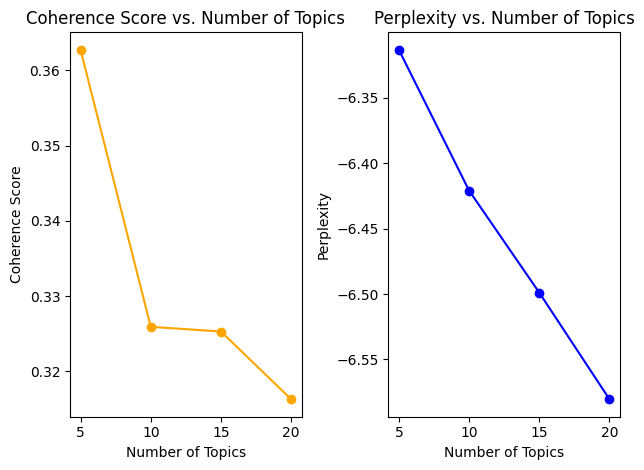

In [23]:
coherence_values = [0.362749385892075, 0.32591669681595875, 0.3252932888800602, 0.316285107227987]
perplexity_values = [-6.313530085866255, -6.421015215891638, -6.498963532393366, -6.580367304994225]

# Plotting Coherence values
plt.figure()

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, coherence_values, marker='o', color='orange')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')

# Plotting Perplexity values
plt.subplot(1, 2, 2)
plt.plot(num_topics_range, perplexity_values, marker='o', color='blue')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.tight_layout()

plt.show()

###Observations
- The model with 5 topics has the highest coherence score, making it the most interpretable. However, it has the highest perplexity, indicating a less optimal fit to the data.

- The model with 20 topics has the lowest perplexity, indicating the best fit to the data, but it has the lowest coherence score, making it less interpretable.

In [29]:
# Assuming lda_model is your trained LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

###Observations:

- Topic 3 is somewhat distinct but overlaps slightly with Topics 4 and 5, suggesting some shared terms or themes.
  - Customer Service:
    - The prominence of terms related to customer service (e.g., "staff," "service," "help," "friendly," "helpful") indicates that Topic 3 is primarily concerned with customer service-related issues.
    - This includes problems with lost or delayed baggage, baggage claims, and the process of checking in baggage.
  - Accommodation and Airport Services:
    - Terms like "hotel," "airport," "food," "meal," and "travel" indicate that issues related to accommodations and airport services are also a key component of this topic.
    - This suggests that problems with hotel arrangements, airport facilities, and in-flight services are contributing to passenger dissatisfaction.

- Topic 1 is somewhat isolated from the other topics, suggesting that it is relatively distinct in terms of the terms it contains.
  - Baggage issues:
    - The prominence of terms related to baggage (e.g., "bag," "bags," "luggage," "baggage," "claim," "checked") indicates that Topic 1 is primarily concerned with baggage-related issues.
    - This includes problems with lost or delayed baggage, baggage claims, and the process of checking in baggage.
  - Delays and Cancellations:
    - The prominence of terms related to delays and cancellations (e.g., "delay," "cancelled," "canceled," "cancel," "late," "on time") indicates that Topic 1 is primarily concerned with baggage-related issues.
    - This includes problems with lost or delayed baggage, baggage claims, and the process of checking in baggage.

- Topic 2 is somewhat isolated from the other topics, suggesting that it is relatively distinct in terms of the terms it contains.
  - Customer Service:
    - Terms like "first," "class," "seats," "seat," "tickets," "ticket," and "cabin" have high relevance within Topic 2, indicating that this topic is heavily focused on seating and class-related issues.
    - Other relevant terms such as "service," "back," "flying," "paid," "good," "business," "economy," and "boarding" suggest that this topic also covers aspects of service quality, class differentiation, and the boarding process.


###Actionable Insighs:
- Enhance Customer Service: Addressing issues related to customer service, such as refunds and cancellations, can help improve overall customer satisfaction.

- Addressing Disparities: The clear distinction of Topic 2 might suggest a need to address specific disparities in the passenger experience between different classes, such as business vs. economy, particularly if negative sentiments are strong in this area

- Improve Baggage Handling: Addressing issues related to baggage handling, such as lost or delayed baggage, can help improve overall customer satisfaction.

- Upgrade Accommodation and Airport Services: Addressing issues related to hotel arrangements, airport facilities, and in-flight services can help improve overall customer satisfaction.


In [30]:
# Assuming lda_model is your trained LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=8,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(lda_display)

###Observations:
- Topic 7 is quite isolated from the other topics, suggesting that it is relatively distinct in terms of the terms it contains.
    - Delays and Weather issues:
        - The prominence of terms related to delays and weather (e.g., "hour," "weather," "delayed," "pm," "minutes," "due," "delay," "hours") indicates that Topic 7 is primarily concerned with delays and weather-related disruptions.
    - Connections and Airports:
        - Terms like "connecting," "dfw," "connection," "another," "charlotte," and "layover" suggest that issues related to flight connections and specific airports are significant concerns within this topic.
        - Passengers may be experiencing problems with missed connections, long layovers, and difficulties at specific airports like Dallas Fort Worth (DFW) and Charlotte.


###Actionable Insights:
- Addressing Delays and Weather Issues: consider strategies to mitigate these issues, such as better communication with passengers during delays and improving contingency plans for weather disruptions.

- Improve Connections and Airports Services: passengers are experiencing issues with missed connections, long layovers, and difficulties at certain airports. Improving the efficiency of connections and providing better support at key airports like DFW and Charlotte could enhance passenger satisfaction.